# Real or Not? NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not

https://www.kaggle.com/c/nlp-getting-started/data

In [1]:
import pandas as pd
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string
import pickle as pk

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train.drop(['keyword','location'], axis=1, inplace=True)
test.drop(['keyword','location'], axis=1, inplace=True)

In [6]:
# Check size of each category
train.groupby('target').size()

target
0    4342
1    3271
dtype: int64

In [7]:
train.shape

(7613, 3)

In [8]:
# Load english stopwords
import nltk
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Parsing text + cleaning + stemm
def parse_out_text(all_text):
    # clean punctuation, make lower case and remove stopwords
    text_string = all_text.translate(str.maketrans("", "", string.punctuation)).split(" ")
    text_string = [word.lower() for word in text_string if word.lower() not in stopwords.words('english')]
    # Stemm text
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for  word in text_string]
    words = " ".join(stemmed) 
    return words

In [10]:
# Text example
text_test = train['text'].iloc[42]
text_test

'Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??'

In [11]:
# Parsed text example
parse_out_text(text_test)

'awesom time visit cfc head offic ancop site ablaz thank tita vida take care us '

In [12]:
%%time
parsed_train = pd.DataFrame(train['text'].apply(parse_out_text))
parsed_train['target'] = train['target']

Wall time: 44.3 s


In [13]:
%%time
parsed_test = pd.DataFrame(test['text'].apply(parse_out_text))

Wall time: 17.8 s


In [14]:
print(parsed_train.isna().sum())

text      0
target    0
dtype: int64


In [15]:
# Loop over all the words in all the texts and increment the counts in the appropriate counter objects
def count_most_common(cat,number):
    count_word = Counter()
    df_cat = parsed_train[parsed_train['target'] == cat]
    for article in df_cat['text']:
        for word in article.split(" "):
            count_word[word] += 1
    return count_word.most_common(number)

In [16]:
count_most_common(1,10)

[('', 1166),
 ('fire', 264),
 ('bomb', 178),
 ('kill', 158),
 ('news', 132),
 ('via', 121),
 ('flood', 120),
 ('disast', 116),
 ('california', 115),
 ('crash', 110)]

In [17]:
count_most_common(0,10)

[('', 1569),
 ('like', 306),
 ('im', 241),
 ('get', 220),
 ('amp', 192),
 ('new', 168),
 ('go', 142),
 ('dont', 139),
 ('one', 134),
 ('bodi', 116)]

In [18]:
parsed_train

,text,target
0,deed reason earthquak may allah forgiv us,1
1,forest fire near la rong sask canada,1
2,resid ask shelter place notifi offic evacu she...,1
3,13000 peopl receiv wildfir evacu order califor...,1
4,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...
7608,two giant crane hold bridg collaps nearbi home...,1
7609,ariaahrari thetawniest control wild fire calif...,1
7610,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj,1
7611,polic investig ebik collid car littl portug eb...,1


In [19]:
parsed_train_text = np.array(parsed_train['text'])
parsed_test_text = np.array(parsed_test['text'])

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Implement vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Fit transform train data
X_train_vector = vectorizer.fit_transform(parsed_train_text)
X_train_vector = X_train_vector.toarray()

# display some words from the vectorizer
words = vectorizer.get_feature_names()
words[1500:1510]

['disco',
 'discov',
 'discoveri',
 'discuss',
 'disea',
 'diseas',
 'disgust',
 'dismiss',
 'disney',
 'disord']

In [21]:
# Apply vectorizer to test data
X_test_vector = vectorizer.transform(parsed_test_text)
X_test_vector = X_test_vector.toarray()

In [22]:
# extract targets from train data
y_train_target = np.array(parsed_train['target'])

In [23]:
print('X_train_vector shape:',X_train_vector.shape)
print('y_train_target shape:',y_train_target.shape)
print('X_test_vector shape:',X_test_vector.shape)

X_train_vector shape: (7613, 10000)
y_train_target shape: (7613,)
X_test_vector shape: (3263, 10000)


In [24]:
# create train test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_vector, 
    y_train_target, 
    stratify=y_train_target, 
    test_size=0.15, 
    random_state=42
)

In [25]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (6471, 10000)
y_train shape: (6471,)
X_test shape: (1142, 10000)
y_test shape: (1142,)


In [26]:
# cross-validator : ShuffleSplit 
sss = StratifiedShuffleSplit(n_splits = 20, test_size = 0.2, random_state = 42) # To avoid over-fitting

### Import classifier ###
from sklearn.svm import LinearSVC
clf = LinearSVC()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ("LSVC",clf)
])

# parameters to tune 
param_grid = {
    'LSVC__C' : [1],
    'LSVC__class_weight' : ['balanced'],
    'LSVC__multi_class' : ['ovr'],
    'LSVC__random_state' : [42],
    'LSVC__max_iter' : [10000],
}  

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

In [28]:
%%time
# training classifier
print (" > training classifier:")
grid.fit(X_train, y_train.ravel())

# best classifier using the cross-validator and the Stratified Shuffle Split 
clf = grid.best_estimator_

# print grid parameters
print ("\n > Best grid search:")
print (grid.best_params_)

# Evaluation metrics
print(classification_report(y_test, clf.predict(X_test)))

 > training classifier:
Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   20.0s finished



 > Best grid search:
{'LSVC__C': 1, 'LSVC__class_weight': 'balanced', 'LSVC__max_iter': 10000, 'LSVC__multi_class': 'ovr', 'LSVC__random_state': 42}
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       651
           1       0.78      0.75      0.76       491

    accuracy                           0.80      1142
   macro avg       0.80      0.80      0.80      1142
weighted avg       0.80      0.80      0.80      1142

Wall time: 20.9 s


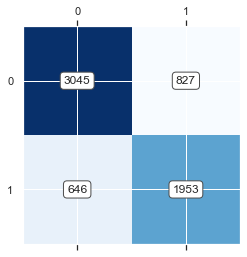

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(conf_mx, cmap='Blues')

for (x, y), value in np.ndenumerate(conf_mx):
    plt.text(x, y, f"{value:.0f}", va="center", ha="center", 
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

In [30]:
# dump classifier in a pickle file
with open("disaster.pkl", 'wb') as file:
    pk.dump(clf, file)

In [31]:
# Load categories
with open("disaster.pkl", 'rb') as fid:
    trained_clf = pk.load(fid)

In [32]:
trained_clf.predict(X_test_vector)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [33]:
df_results = pd.DataFrame({
    'id':np.array(test['id']),
    'text':np.array(test['text']),
    'target':trained_clf.predict(X_test_vector)
})

df_results['target'].value_counts()

0    1924
1    1339
Name: target, dtype: int64

In [34]:
df_results[df_results['target'] == 1].sample(n=5)

,id,text,target
1916,6460,I made him fall and hegot injured https://t.co...,1
2589,8619,#Sismo DETECTADO #JapÌ_n [Report 6] 01:02:42 O...,1
1257,4134,#KondoByJaymOnI U.S. in record hurricane droug...,1
1047,3441,HillaryÛªs Bimbo Eruptions and Questionable F...,1
1319,4346,A dust storm in Pheonix. http://t.co/AMgfOnzUSD,1


In [35]:
df_results[df_results['target'] == 0].sample(n=5)

,id,text,target
2494,8323,@KurtSchlichter Grandpa fought his way across ...,0
808,2653,pkadlik : jojowizphilipp and I have a crush on...,0
512,1678,Project Syndicate: A Marshall Plan for the Uni...,0
1725,5820,Created save #666 on my current Fallout 3 play...,0
2195,7347,Watch Sarah Palin OBLITERATE Planned Parenthoo...,0


In [36]:
df_submission = df_results.drop('text',axis=1)
df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [37]:
df_submission.to_csv('submission.csv', index=False)